In [1]:
import pandas as pd
import numpy as np
from generate_data import generate_data
import matplotlib.pyplot as plt
from discrete_lognormal import DiscreteLognormal
import statsmodels.api as sm
plt.rcParams["figure.figsize"] = (12,6)
import warnings
from timeit import default_timer as timer

/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
data = generate_data()

In [3]:
data.x_df.head()
# days since start is z normalized

,intercept,days_since_start,days_since_start_squared,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,seasonality_cos,seasonality_sin
0,1.0,-1.729679,2.228932,0,0,0,0,0,1,0.999852,0.017213
1,1.0,-1.726517,2.216707,0,0,0,0,0,0,0.999407,0.034422
2,1.0,-1.723355,2.204505,1,0,0,0,0,0,0.998667,0.051620
3,1.0,-1.720193,2.192325,0,1,0,0,0,0,0.997630,0.068802
4,1.0,-1.717031,2.180168,0,0,1,0,0,0,0.996298,0.085965


In [4]:
gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
gpois_res = gpois_mdl.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 6.031884
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 7


In [5]:
gpois_res.params

intercept                   5.231842
days_since_start            0.346662
days_since_start_squared   -0.120674
day_of_week_1               0.245089
day_of_week_2               0.289024
day_of_week_3               0.280834
day_of_week_4               0.288438
day_of_week_5               0.172481
day_of_week_6               0.063370
seasonality_cos             0.142115
seasonality_sin            -0.060069
alpha                       7.174686
dtype: float64

In [6]:
print(gpois_res.summary2())

                       Results: GeneralizedPoisson
Model:                 GeneralizedPoisson  Pseudo R-squared:  0.049      
Dependent Variable:    y                   AIC:               13233.8268 
Date:                  2022-04-05 12:51    BIC:               13293.8089 
No. Observations:      1095                Log-Likelihood:    -6604.9    
Df Model:              10                  LL-Null:           -6942.7    
Df Residuals:          1084                LLR p-value:       1.0520e-138
Converged:             1.0000              Scale:             1.0000     
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
intercept                 5.2318   0.0392 133.4499 0.0000  5.1550  5.3087
days_since_start          0.3467   0.0148  23.4267 0.0000  0.3177  0.3757
days_since_start_squared -0.1207   0.0141  -8.5607 0.0000 -0.

In [7]:
# Marginal effects
me = gpois_res.get_margeff(method='dydx')
me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
 GeneralizedPoisson Marginal Effects 
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
============================================================================================
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
days_since_start            84.6137      3.852     21.968      0.000      77.065      92.163
days_since_start_squared   -29.4542      3.472     -8.483      0.000     -36.259     -22.649
day_of_week_1               59.8217     12.529      4.775      0.000      35.265      84.378
day_of_week_2               70.5454     12.535      5.628      0.000      45.978      95.113
day_of_week_3               68.5463     12.533      5.469      0.000      43.982      93.110
day_of_week_4               70.4022     12.495      5.634      0.000      45.912      94.893
day_of_week_5               42.0994     12.702      3.314      0.001      17.203      66.995
day_of_week_6               15.4674     12.834      1.205      0.228      -9.686      40.621
seasonality_cos             34.6875      4.708      7.367      0.000      25.459      43.916
seasonality_sin            -14.6618      4.748     -3.088      0.002     -23.967      -5.356
============================================================================================
"""

In [8]:
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]

In [9]:
# np.seterr(divide = 'warn')
# np.seterr(invalid= 'warn')

start_params = np.zeros(22)
start_params[:11] = gpois_res.params[:11]
start_params[11] = -1.
mod = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)

mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=1e-4)
print(mod_res.summary())
print(f"True Beta: {data.beta}")
print(f"True Alpha: {data.alpha}")

Optimization terminated successfully.
         Current function value: 5.928905
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 10
                          DiscreteLognormal Results                           
Dep. Variable:                      y   Log-Likelihood:                -6492.2
Model:              DiscreteLognormal   AIC:                         1.301e+04
Method:            Maximum Likelihood   BIC:                         1.306e+04
Date:                Tue, 05 Apr 2022                                         
Time:                        12:51:45                                         
No. Observations:                1095                                         
Df Residuals:                    1084                                         
Df Model:                          10                                         
                                     coef    std err          z      P>|z|      [0.0

In [10]:
# Test Newton method
mod_res_newton = mod.fit(method = "newton", start_params = start_params, maxiter=100, penalty=1e-4)

Optimization terminated successfully.
         Current function value: 5.928905
         Iterations 7


In [11]:
# Test first-order EM
mod_em_first = mod.fit(
    start_params=start_params,
    method="EM", 
    use_hessian=False,
    maxiter=1000,
    step_size=1e-3,
    tol=1e-6,
    penalty=1e-4)

In [12]:
# Test second-order EM
start_params[11] = -0.5
mod_em_second = mod.fit(
    start_params=start_params,
    method="EM",
    use_hessian=True,
    maxiter=100,
    tol=1e-6,
    penalty=1e-4)
# Sensitive to good starting values

In [13]:
def fittedmean(res):
    return pd.Series(res.exog @ res.params[:11])

def fittedvar(res):
    return pd.Series(np.exp(res.exog @ res.params[11:]))

def mse(yhat, y):
    r = y - yhat
    return np.mean(r**2)

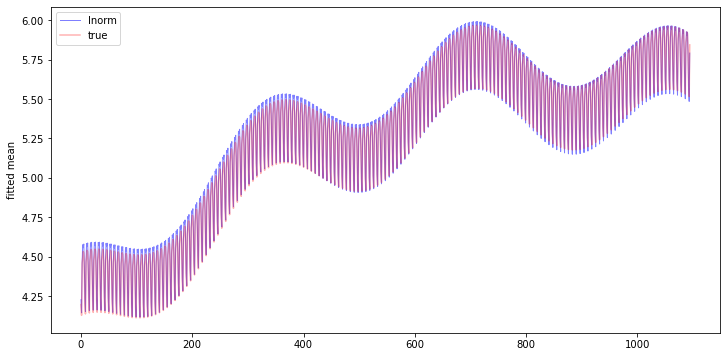

In [14]:
fittedmean(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

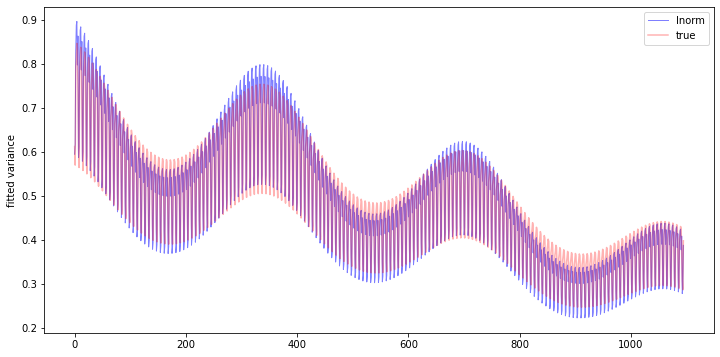

In [15]:
fittedvar(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.sigma, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted variance")
plt.show()

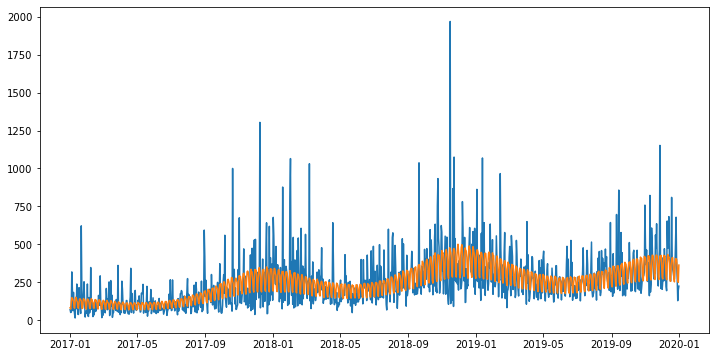

In [16]:
Y_hat = mod_res.predict(n=1000)
plt.plot(data.days, data.y)
plt.plot(data.days, Y_hat)
plt.show()

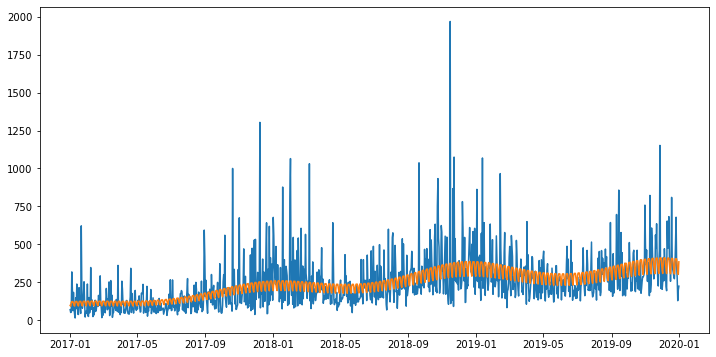

In [17]:
plt.plot(data.days, data.y)
plt.plot(data.days, gpois_res.predict())
plt.show()

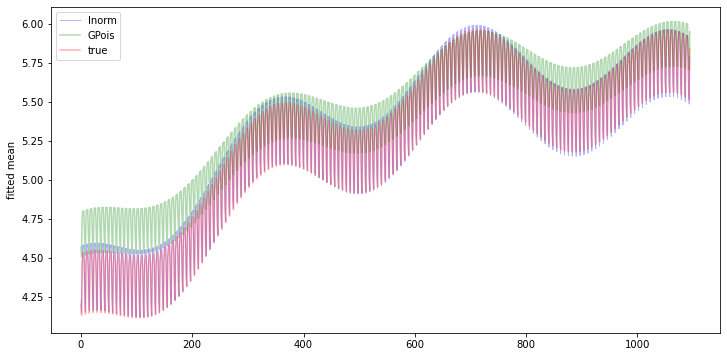

In [18]:
fittedmean(mod_res).plot(alpha = 0.3, color = "blue", linewidth = 1, label = "lnorm")
gpois_res.fittedvalues.plot(alpha = 0.3, color = "green", label = "GPois")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

In [19]:
# Negative Hessian is PD at optimal values
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, -1., -0.2, -0.03, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.16, -0.05])
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
np.linalg.eigvals(-mod.hessian(starting_vals))

array([1251.78650973, 1191.62965996, 1131.33596809,  939.68241458,
        660.20637405,  537.34298161,  481.26034019,  336.54976984,
        261.43551195,  227.19962737,   19.69333664,    6.87133761,
         47.25280998,  100.85886729,   82.79227922,   91.11433778,
         88.27980269,  159.68717365,  148.55612701,  151.37883216,
        154.63430124,  156.7762597 ])

In [20]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     bs = mod_res.bootstrap(nrep=1, method="ncg", store = 0, disp = 0) # we can bootstrap SE

In [21]:
# bs[0] #mean estimates

## Simulation 

In [22]:
# What else should we test?
N = 50
penalty = 1e-4
sim_params = list()
sim_mse = list()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        sim_params.append(["pois"] + pois_res.params[:11].tolist())
        
        gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
        gpois_res = gpois_mdl.fit(disp=0)
        sim_params.append(["gpois"]+ gpois_res.params[:11].tolist())
        
        NB1_mdl = sm.NegativeBinomialP(data.y, data.x_df,p=1)
        NB1_res = NB1_mdl.fit(disp=0)
        sim_params.append(["NB1"]+ NB1_res.params[:11].tolist())
        
        mod = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        sim_params.append(["lnorm"] + mod_res.params[:11].tolist()) # Just the model coeffecients

        data = generate_data() #new data
        Xnew = data.x_df
        # out of sample prediction MSE
        sim_mse.append([mse(mod_res.predict(exog=Xnew), data.y), mse(pois_res.predict(exog=Xnew), data.y), 
                        mse(gpois_res.predict(exog=Xnew), data.y), mse(NB1_res.predict(exog=Xnew), data.y)])


In [23]:
sim_params = pd.DataFrame(sim_params, columns=["model"] + data.x_df.columns.to_list())

In [24]:
sim_params.groupby(by = "model").mean().T

model,NB1,gpois,lnorm,pois
intercept,5.174057,5.217772,4.994889,5.073331
days_since_start,0.341145,0.350132,0.396918,0.343459
days_since_start_squared,-0.141361,-0.131190,-0.169656,-0.170583
day_of_week_1,0.293377,0.242844,0.334748,0.397641
day_of_week_2,0.323113,0.268621,0.367921,0.436576
day_of_week_3,0.357787,0.294636,0.404722,0.486259
day_of_week_4,0.349001,0.285003,0.395816,0.476297
day_of_week_5,0.233225,0.194927,0.265057,0.313592
day_of_week_6,0.063745,0.055695,0.076950,0.083393
seasonality_cos,0.178552,0.147557,0.197388,0.238538


In [25]:
#MSE
pd.DataFrame(sim_mse, columns=["lnorm", "pois", "gpois", "NB1"]).describe()

,lnorm,pois,gpois,NB1
count,50.000000,50.000000,50.000000,50.000000
mean,20489.714029,20538.194817,21095.949889,20750.951301
std,3267.301316,3289.266139,3460.428919,3393.586564
min,14597.143977,14536.261899,15042.083842,14806.590970
25%,17860.432204,17910.833527,18121.363295,17889.312497
50%,19717.489276,19747.517605,20317.351997,19950.194612
75%,22538.049243,22603.865992,23102.371697,22750.552121
max,29230.855948,29310.519654,29970.194223,29494.561929


In [26]:
N = 50
sim_solver_times = list()
sim_solver_fcalls = list()
penalty = 1e-4

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        fcalls = []
        
        # Seed with poisson parameters
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        
        mod = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)
        
        start = timer()
        mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        ncg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "cg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        cg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        bfgs = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "powell", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        powell = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        sim_solver_times.append([ncg, cg, bfgs, powell])
        sim_solver_fcalls.append(fcalls)

In [27]:
pd.DataFrame(sim_solver_times, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,0.203430,0.396941,0.093282,0.448807
std,0.013441,0.044373,0.002073,0.027023
min,0.185270,0.299489,0.090091,0.357197
25%,0.192242,0.358108,0.091496,0.442070
50%,0.204859,0.398218,0.093472,0.443184
75%,0.208541,0.430224,0.093878,0.445793
max,0.254706,0.477016,0.100049,0.531343


In [28]:
pd.DataFrame(sim_solver_fcalls, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,16.060000,131.380000,26.700000,1162.920000
std,4.622085,15.110329,0.505076,71.145393
min,13.000000,98.000000,26.000000,920.000000
25%,14.000000,118.000000,26.000000,1147.250000
50%,15.000000,132.500000,27.000000,1150.000000
75%,17.000000,141.750000,27.000000,1152.750000
max,42.000000,159.000000,28.000000,1391.000000
